### Simulation: Masternode Yield Farming

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/research/impermanent_loss","")
os.chdir(cwd)

from python.dev.helper import Helper

from python.dev.simulation import SimulationOrchestrator
from python.dev.simulation import EventQueue
from python.dev.simulation import EventExecutor
from python.dev.simulation.batch import ActionBatch
from python.dev.simulation.batch import MergeBatch

from python.dev.agent import TokenAgent
from python.dev.agent import LPTokenAgent
from python.dev.agent import UserAgent

from python.dev.action import MintAction
from python.dev.action import DepositAction
from python.dev.action import LPDepositChainAction
from python.dev.action import DepositChainAction
from python.dev.action import WithdrawChainAction
from python.dev.action import WithdrawAction
from python.dev.action import SwapAction
from python.dev.event import Mint
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.event import Swap

from python.dev.math.model import BrownianModel
from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import ModelQueue

from python.dev.lp import LiquidityPool
from python.dev.lp.event import LPEvent
from python.dev.lp.event import MintLPEvent
from python.dev.lp.event import DepositLPEvent
from python.dev.lp.event import SwapLPEvent

In [2]:
from python.dev.cpt import Liquidity
import scipy.special as sps 

class SimulateLiquidity():
    
    def __init__(self, x_real, y_real, x_name, y_name, max_trade = 1000):       
        self.liq_obj = Liquidity(x_real, y_real, x_name, y_name)
        self.max_trade = max_trade
        self.shape = None
        self.scale = None

    def get_max_trade(self):
        return self.max_trade       
        
    def get_liquidity_obj(self):
        return self.liq_obj
        
    def set_params(self):
        self.shape, self.scale = 1, self.max_trade/5    
        
    def gen_delta_y(self):    
        self.set_params()
        return np.random.gamma(self.shape, self.scale)
    
    def gen_new_position(self, p):
        delta_y = self.gen_delta_y()
        delta_x = (self.liq_obj.get_y_real() + delta_y)/p - self.liq_obj.get_x_real()
        self.liq_obj.add_delta_y(delta_y)
        self.liq_obj.add_delta_x(delta_x)   
        
    def apply(self, p_arr):
        delta_x_arr = np.array([])
        delta_y_arr = np.array([])
        for p in p_arr: 
            self.gen_new_position(p)
            delta_x_arr = np.append(delta_x_arr,self.liq_obj.get_x_delta()) 
            delta_y_arr = np.append(delta_y_arr,self.liq_obj.get_y_delta()) 
            
        return delta_x_arr, delta_y_arr    

In [3]:
def gen_xy_value(p, x_mu_deposit, sigma=1):
    y_mu_deposit = p*x_mu_deposit
    #x_deposit_value = np.random.normal(x_mu_deposit, sigma)
    #y_withdraw_value = np.random.normal(y_mu_deposit, sigma)
    x_deposit_value = x_mu_deposit
    y_withdraw_value = y_mu_deposit    
    xy_values = np.array((x_deposit_value, y_withdraw_value))
    return xy_values


def gen_xy_arr(p_arr, x_mu_deposit=1, sigma=1):
    xy_vals_arr = np.array([])
    for p in p_arr:
        xy_vals = gen_xy_value(p, x_mu_deposit, sigma)
        if len(xy_vals_arr) == 0:
            xy_vals_arr = np.array(xy_vals) 
        else:
            xy_vals_arr = np.vstack((xy_vals_arr,xy_vals))
            
    return xy_vals_arr

### Initialize Agents

In [4]:
USER1 = UserAgent('USER1')
SYS = TokenAgent('SYS')
DAI = TokenAgent('DAI')
SYS_DAI_LP = LiquidityPool('SYS/DAI', USER1, SYS, DAI)
SYS_DAI = LPTokenAgent('SYS_DAI_LP', SYS_DAI_LP)

### Mint Tokens

In [5]:
apy = 0.1
t_delta = 109*24*3600
N_RUNS = 5*365

In [6]:
SYS_mint1 = Mint(5000, apy, True)
DAI_mint1 = Mint(1000, apy, True)
SYS_DAI_LP_mint1 = Mint(0, apy, True)

m_action1 = MintAction(SYS_mint1, SYS, USER1)
m_action2 = MintAction(DAI_mint1, DAI, USER1)
m_action3 = MintAction(SYS_DAI_LP_mint1, SYS_DAI, USER1)

In [7]:
sBatch = ActionBatch('SETUP1')
sBatch.init_action(m_action1)
sBatch.init_action(m_action2)
sBatch.init_action(m_action3)

setup_batch = sBatch.generate()

In [8]:
sBatch.inspect()

** SETUP1 INIT BATCH **
USER1 MINTs 5000.00 SYS 
USER1 MINTs 1000.00 DAI 
USER1 MINTs 0.00 SYS_DAI_LP 


### Setup Actions

### Batchset 2

In [9]:
N_RUNS = 1825

In [39]:
b = BrownianModel(0.2)
p_arr = b.gen_gbm(0.1, 1, N_RUNS, 1)
xy_arr = gen_xy_arr(p_arr, 100, 10)

sim_liq = SimulateLiquidity(10000, 2000, 'SYS','DIA')
x_delta, y_delta = sim_liq.apply(p_arr)

r_deposit_model = np.random.normal(100, 10, N_RUNS)
r_withdraw_model = np.random.normal(20, 10, N_RUNS)

#r_deposit_model = x_delta
#r_withdraw_model = y_delta

In [40]:
r_deposit_obj = ModelQueue().apply(r_deposit_model)
r_withdraw_obj = ModelQueue().apply(r_withdraw_model)

r_sub_swap_obj1 = ModelQueue().apply(r_withdraw_model)
r_sub_swap_obj2 = ModelQueue().apply(r_deposit_model)

t_delta_model = TimeDeltaModel().apply(p = 0.00001, n = N_RUNS)
t_delta_obj3 = ModelQueue().apply(t_delta_model)
t_delta_obj4 = ModelQueue().apply(t_delta_model)

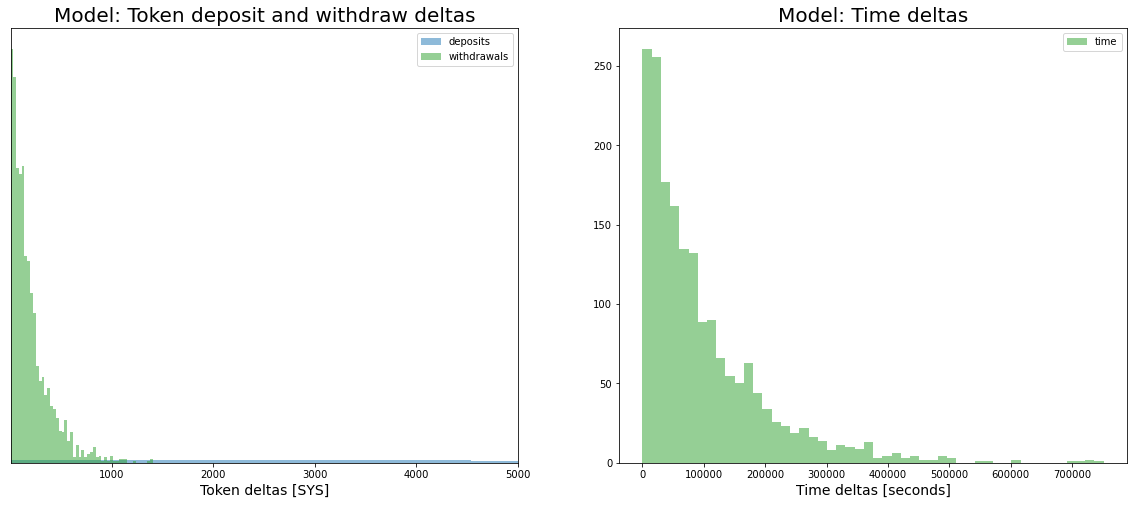

In [43]:
import seaborn as sns
fig, (dist1_ax, dist2_ax) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize=(20, 8))

r_obj1 = x_delta
r_obj2 = y_delta

blue, _, red = sns.color_palette()[:3]
dist1_ax.hist(r_obj1, 50, color=blue, density=True, alpha=0.5, lw=0, label='deposits');
dist1_ax.hist(r_obj2, 50, color=red, density=True, alpha=0.5, lw=0, label='withdrawals');
dist1_ax.set_xlim(left=0)
dist1_ax.set_xlabel('Token deltas [SYS]', fontsize=14)
dist1_ax.set_yticks([])
dist1_ax.set_xlim(5, 5000);
dist1_ax.set_title("Model: Token deposit and withdraw deltas", fontsize=20);
dist1_ax.legend(loc='upper right');

dist2_ax.hist(t_delta_model, 50, color=red, alpha=0.5, lw=0, label='time');
dist2_ax.set_xlabel('Time deltas [seconds]', fontsize=14);
dist2_ax.set_title("Model: Time deltas", fontsize=20);
dist2_ax.legend();

In [13]:
deposit_event = Deposit(apy, r_deposit_obj, t_delta_obj3) 
sub_withdraw_event = Withdraw(apy, r_sub_swap_obj1, 0)
sub_deposit_event = Deposit(apy, r_sub_swap_obj2, t_delta_obj4)
withdraw_event = Withdraw(apy, r_withdraw_obj, 0) 

In [14]:
# Deposit SYS
d_action1 = DepositAction(deposit_event, SYS, USER1, SYS_mint1.get_id())

# Swap SYS for DAI
sub_w_action = WithdrawAction(sub_withdraw_event, SYS, USER1, SYS_mint1.get_id())
sub_d_action = DepositAction(sub_deposit_event, DAI, USER1, DAI_mint1.get_id())
s_action1 = SwapAction(sub_w_action, sub_d_action)

# Withdraw DAI and SYS proceeds 
w_action1 = WithdrawChainAction(s_action1, DAI, USER1, DAI_mint1.get_id())
w_action2 = WithdrawAction(withdraw_event, SYS, USER1, SYS_mint1.get_id())

# Deposit withdrawn DAI and SYS in LP
d_action2 = LPDepositChainAction(w_action1, w_action2, SYS_DAI, USER1, SYS_DAI_LP_mint1.get_id())

In [15]:
aBatch = ActionBatch('RUN1', N_RUNS)
aBatch.add_action(d_action1)
aBatch.add_action(s_action1)
aBatch.add_action(w_action1)
aBatch.add_action(w_action2)
aBatch.add_action(d_action2)

In [16]:
aBatch.inspect()
action_batch = aBatch.generate()

** RUN1 ACTION BATCH **
USER1 DEPOSITs SYS 
USER1 SWAPs SYS for DAI 
USER1 WITHDRAWs DAI proceeds
USER1 WITHDRAWs SYS 
USER1 DEPOSITs DAI and SYS proceeds into SYS_DAI_LP

 ** REPEAT BATCH ** 
 1825 times

 ** RUNTIME for 1st BATCH ** 
79232 seconds


### Setup event queue

In [17]:
q = EventQueue()
q.add_setup_batch(setup_batch)
q.add_action_batch(action_batch)
q.freeze()

### Execute events

In [18]:
all_batches = q.get_all_batches()

orchestrator = SimulationOrchestrator(verbose = False)
executor = EventExecutor(q, orchestrator)
executor.run()

In [19]:
#orchestrator.print_logs()

### Analyze

In [20]:
tSYS = SYS.get_token()
tDAI = DAI.get_token()
tSYS_DAI = SYS_DAI.get_token()

SYS_addr1 = SYS.get_address(SYS_mint1.get_id())
DAI_addr1 = DAI.get_address(DAI_mint1.get_id())
SYS_DAI_addr1 = SYS_DAI.get_address(SYS_DAI_LP_mint1.get_id())

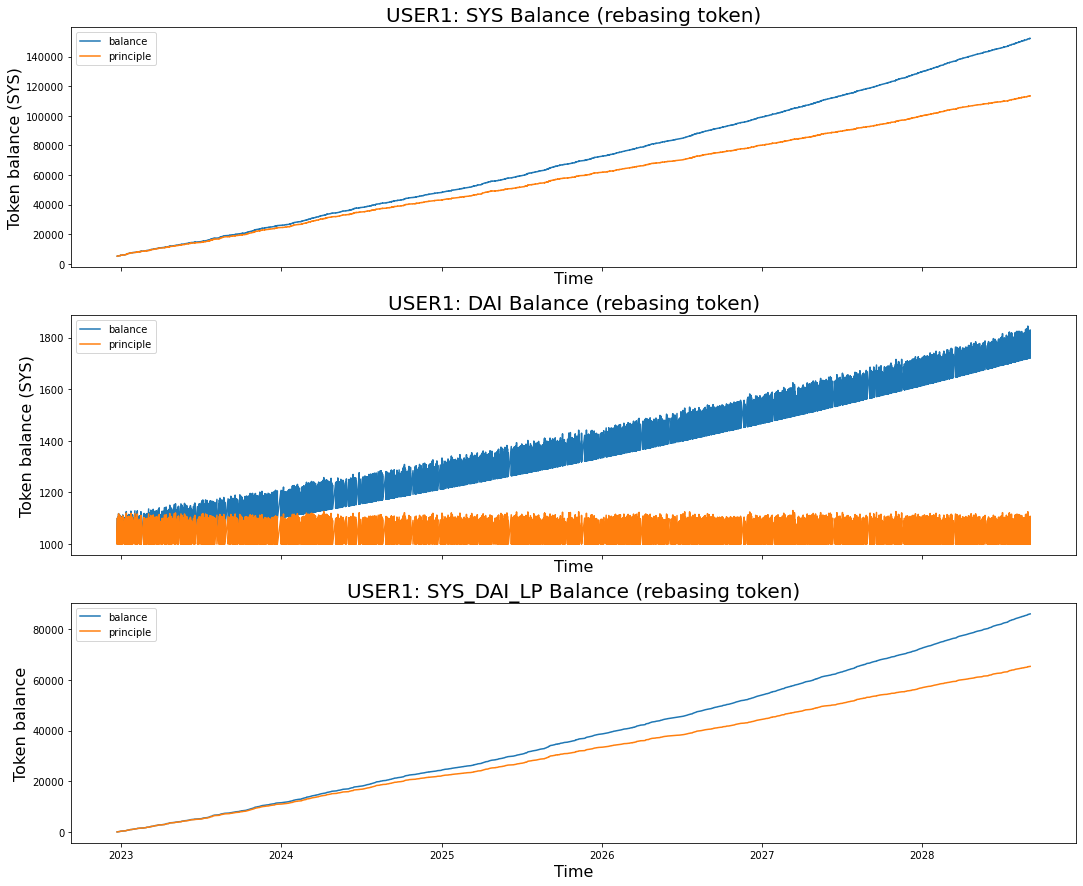

In [21]:
SYS_states1 = tSYS.get_state_series(SYS_addr1)
principle = SYS_states1.get_principle() 
balance = SYS_states1.get_balance() 
tSamp = SYS_states1.get_tstamp()  

fig, (SYS_ax, DAI_ax, SYS_DAI_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(18, 15))

SYS_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_ax.set_title("USER1: SYS Balance (rebasing token)", fontsize=20)
SYS_ax.set_ylabel("Token balance (SYS)", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_states1 = tDAI.get_state_series(DAI_addr1)
principle = DAI_states1.get_principle() 
balance = DAI_states1.get_balance() 
tSamp = DAI_states1.get_tstamp() 

DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
DAI_ax.set_title("USER1: DAI Balance (rebasing token)", fontsize=20)
DAI_ax.set_ylabel("Token balance (SYS)", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

SYS_DAI_states1 = tSYS_DAI.get_state_series(SYS_DAI_addr1)
principle = SYS_DAI_states1.get_principle() 
balance = SYS_DAI_states1.get_balance() 
tSamp = SYS_DAI_states1.get_tstamp() 

principle1 = principle
tSamp1 = tSamp

SYS_DAI_ax.plot(tSamp[1:], balance[1:], label='balance') 
SYS_DAI_ax.plot(tSamp[1:], principle[1:], label='principle') 
SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Balance (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("Token balance", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

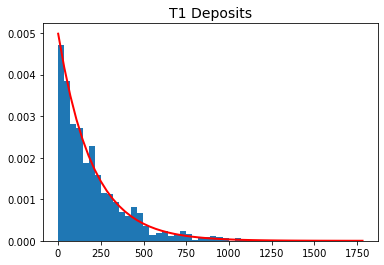

In [22]:
import scipy.special as sps 
max_trade = 1000
shape, scale = 1, max_trade/5  
s = np.random.gamma(shape, scale, 1000)

count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /  
                     (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')  
plt.title("T1 Deposits", fontsize=14)
plt.show()

In [23]:
np.random.gamma(shape, scale)

170.74055918318138

In [24]:
from python.dev.cpt import Liquidity

In [25]:
liq = Liquidity(100, 20, 'SYS','DIA')

In [26]:
liq.get_price()

0.19999999999999998

In [27]:
liq.get_y_real()

20

In [28]:
liq.get_x_real()

100

In [29]:
p_arr[1]*liq.get_x_real()

19.760684936393062

In [30]:
p_arr[0:5]

array([0.2       , 0.19760685, 0.19120845, 0.18651881, 0.18719493])

In [31]:
class SimulateLiquidity():
    
    def __init__(self, x_real, y_real, x_name, y_name, max_trade = 1000):       
        self.liq_obj = Liquidity(x_real, y_real, x_name, y_name)
        self.max_trade = max_trade
        self.shape = None
        self.scale = None

    def get_max_trade(self):
        return self.max_trade       
        
    def get_liquidity_obj(self):
        return self.liq_obj
        
    def set_params(self):
        self.shape, self.scale = 1, self.max_trade/5    
        
    def gen_delta_y(self):    
        self.set_params()
        return np.random.gamma(self.shape, self.scale)
    
    def gen_new_position(self, p):
        delta_y = self.gen_delta_y()
        delta_x = (self.liq_obj.get_y_real() + delta_y)/p - self.liq_obj.get_x_real()
        self.liq_obj.add_delta_y(delta_y)
        self.liq_obj.add_delta_x(delta_x)   
        
    def apply(self, p_arr):
        delta_x_arr = np.array([])
        delta_y_arr = np.array([])
        for p in p_arr: 
            self.gen_new_position(p)
            delta_x_arr = np.append(delta_x_arr,self.liq_obj.get_x_delta()) 
            delta_y_arr = np.append(delta_y_arr,self.liq_obj.get_y_delta()) 
            
        return delta_x_arr, delta_y_arr    

In [32]:
sim_liq = SimulateLiquidity(1000, 200, 'SYS','DIA')
x_delta, y_delta = sim_liq.apply(p_arr)

liq = sim_liq.get_liquidity_obj()
liq.get_price()

0.021654306565660857

In [33]:
p_arr[-1]

0.02165430656566086

In [34]:
y

array([4.98390867e-03, 4.17085070e-03, 3.49043225e-03, 2.92101496e-03,
       2.44449048e-03, 2.04570459e-03, 1.71197527e-03, 1.43268943e-03,
       1.19896533e-03, 1.00337019e-03, 8.39683778e-04, 7.02700612e-04,
       5.88064416e-04, 4.92129580e-04, 4.11845228e-04, 3.44658193e-04,
       2.88431824e-04, 2.41378034e-04, 2.02000439e-04, 1.69046772e-04,
       1.41469055e-04, 1.18390272e-04, 9.90764847e-05, 8.29134827e-05,
       6.93872581e-05, 5.80676560e-05, 4.85946954e-05, 4.06671215e-05,
       3.40328251e-05, 2.84808254e-05, 2.38345600e-05, 1.99462707e-05,
       1.66923037e-05, 1.39691778e-05, 1.16902935e-05, 9.78317864e-06,
       8.18718403e-06, 6.85155457e-06, 5.73381518e-06, 4.79842000e-06,
       4.01562203e-06, 3.36052706e-06, 2.81230206e-06, 2.35351263e-06,
       1.96956856e-06, 1.64825982e-06, 1.37936830e-06, 1.15434283e-06,
       9.66027252e-07, 8.08432840e-07, 6.76547846e-07])

In [35]:
x

NameError: name 'x' is not defined

In [ ]:
sim_liq.gen_delta_y()

In [ ]:
liq = sim_liq.get_liquidity_obj()
liq.get_x_real()

In [ ]:
x = np.array([])
x = np.append(x,1)
x

In [ ]:
sim_liq = SimulateLiquidity(1000, 200, 'SYS','DIA')

liq = sim_liq.get_liquidity_obj()
liq.calc()
liq.get_price()

In [ ]:
liq = Liquidity(1000, 200, 'SYS','DIA')

In [ ]:
delta_y = np.random.gamma(shape, scale)
delta_x = (liq.get_y_real() + delta_y)/p_arr[1] - liq.get_x_real()
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
#liq.calc()
#liq.get_price()

In [ ]:
delta_y = np.random.gamma(shape, scale)
delta_x = (liq.get_y_real() + delta_y)/p_arr[2] - liq.get_x_real()
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
#liq.calc()
#liq.get_price()

In [ ]:
delta_y = np.random.gamma(shape, scale)
delta_x = (liq.get_y_real() + delta_y)/p_arr[3] - liq.get_x_real()
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
liq.calc()
liq.get_price()

In [ ]:
liq.get_x_real()

In [ ]:
liq.get_y_real()

In [ ]:
liq.get_price()

In [ ]:
liq.add_delta_y(delta_y)
liq.add_delta_x(delta_x)
liq.calc()
liq.get_price()

In [ ]:
liq.get_x_real()

In [ ]:
y_new = 10

(liq.get_x_real()*y_new)/(liq.get_y_real()+y_new)


In [ ]:
30/133

In [ ]:
liq.get_y_real()

In [ ]:
liq = Liquidity(100, 20, 'SYS','DIA')

In [ ]:
delta_y = (p_arr[1]-p_arr[0])*liq.get_x_real() 
liq.add_delta_y(delta_y)
liq.calc()
liq.get_price()

In [ ]:
liq.get_x_real()

In [ ]:
delta_y = (p_arr[2]-p_arr[1])*liq.get_x_real()
liq.add_delta_y(delta_y)
liq.calc()
liq.get_price()

In [ ]:
delta_y = (p_arr[3]-p_arr[2])*liq.get_x_real()
liq.add_delta_y(delta_y)
liq.calc()
liq.get_price()

In [ ]:
liq.get_y_real()

In [ ]:
liq.get_x_real()

In [ ]:
p_arr[0:5]

In [ ]:
#SYS_DAI_LP_prices[1:]

In [ ]:
SYS_DAI_LP = SYS_DAI.get_lp().get_lp_events()
SYS_DAI_LP_prices = SYS_DAI_LP.get_prices()
SYS_DAI_LP_dates = SYS_DAI_LP.get_dates()

fig, (SYS_DAI_ax) = plt.subplots(nrows=1, sharex=True, sharey=False, figsize=(18, 5))
SYS_DAI_ax.plot(SYS_DAI_LP_dates[1:], 1/SYS_DAI_LP_prices[1:], label='prices') 
SYS_DAI_ax.plot(SYS_DAI_LP_dates[1:], p_arr[2:], color = 'r', label='prices') 

SYS_DAI_ax.set_title("USER1: SYS_DAI_LP Prices (rebasing token)", fontsize=20)
SYS_DAI_ax.set_ylabel("SYS / DIA", fontsize=16)
SYS_DAI_ax.set_xlabel('Time', fontsize=16)
SYS_DAI_ax.legend()

In [ ]:
#orchestrator.print_logs()

In [ ]:
SYS_DAI_LP.get_event(1).get_liquidity().get_y_real()

In [ ]:
SYS_DAI_LP.get_event(1).get_liquidity().get_x_real()

In [ ]:
SYS_DAI_LP.get_event(1).get_liquidity().get_price()

In [ ]:
SYS_DAI_LP.get_event(3).get_liquidity().get_liquidity_val()

In [ ]:
#b = BrownianModel(0.2)
#p_arr = b.gen_gbm(0.1, 1, 365, 1)
#xy_arr = gen_xy_arr(p_arr, 100)